## Introduction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy 

import importlib

import os
import sys
sys.path.append("../")
import methods  
importlib.reload(methods)

<module 'methods' from '/Users/timothysudijono/Projects/statistics/empirical_bayes/CompoundWelfareMaximization/analyses/../methods.py'>

In [ ]:
def load_data_for_outcome(est_var):
    """
    Load the processed data for a given outcome variable
    Filter out missing values and values where the standard error is too large
    """
    df = pd.read_feather("data/oa_data_used.feather")
    se_var = est_var + "_se"
    subset = df[[est_var, se_var, "czname", "state", "county", "tract"]].dropna()
    thresh = subset[se_var].quantile(0.995)
    subset = subset.loc[subset[se_var] <= thresh].reset_index(drop=True)

    return subset

est_var = "kfr_top20_black_pooled_p25"
df = load_data_for_outcome(est_var)
estimates = df[est_var].values
standard_errors = df[est_var + "_se"].values

In [4]:
print(df.shape)
df.head(10)

(13600, 6)


,kfr_top20_black_pooled_p25,kfr_top20_black_pooled_p25_se,czname,state,county,tract
0,0.266531,0.135016,Phoenix,4,13,40530
1,0.129480,0.111129,Phoenix,4,13,60901
2,-0.028518,0.033581,Phoenix,4,13,60903
3,0.061770,0.080799,Phoenix,4,13,60904
4,0.062708,0.083388,Phoenix,4,13,61009
5,0.066941,0.071879,Phoenix,4,13,61011
6,-0.040516,0.040181,Phoenix,4,13,61012
7,0.323974,0.112913,Phoenix,4,13,61014
8,0.070399,0.060588,Phoenix,4,13,61015
9,0.043843,0.062666,Phoenix,4,13,61022


Text(0, 0.5, 'Treatment Effects')

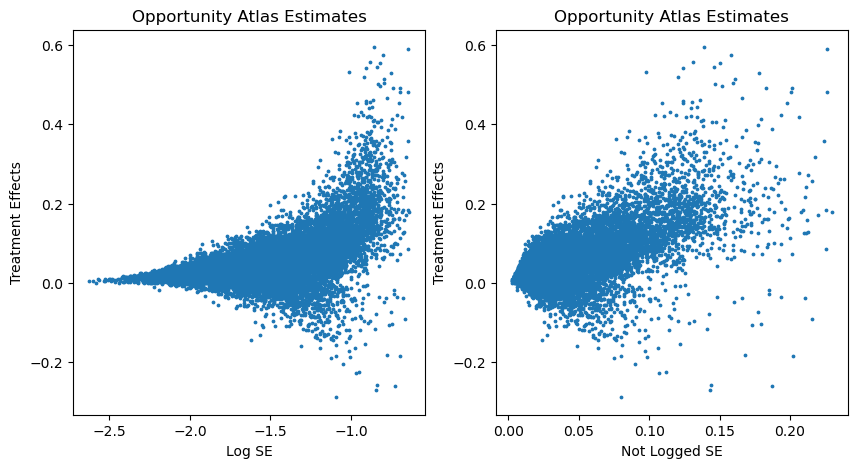

In [5]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].scatter(np.log10(standard_errors), estimates, s = 3)
ax[0].set_title("Opportunity Atlas Estimates")
ax[0].set_xlabel("Log SE")
ax[0].set_ylabel("Treatment Effects")

ax[1].scatter(standard_errors, estimates, s = 3)
ax[1].set_title("Opportunity Atlas Estimates")
ax[1].set_xlabel("Not Logged SE")
ax[1].set_ylabel("Treatment Effects")

Optimal Threshold: -1.492985971943888


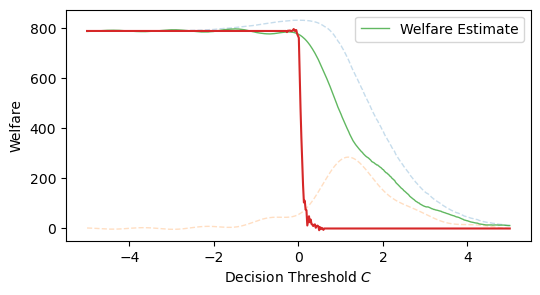

In [12]:
Xs = estimates
sigmas = standard_errors
ts = Xs/sigmas

_ = methods.heteroskedastic_normal_welfare_estimator(Xs, sigmas, smoothen_nn=False)


cb_welfare = methods.coupled_bootstrap(Xs, sigmas, eps = 0.01)
grid = np.linspace(-5, 5, len(cb_welfare))
plt.plot(grid, cb_welfare)

#plt.savefig("opportunity_atlas_analysis.pdf", bbox_inches='tight')

(-0.2, 0.6)

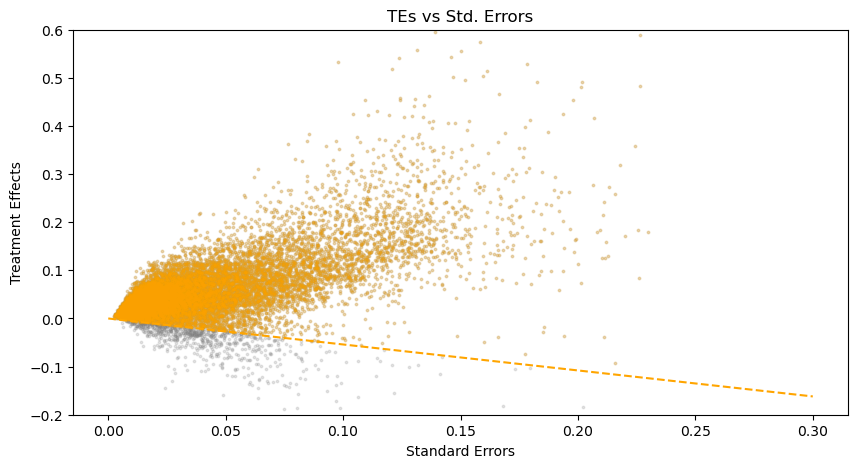

In [9]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.scatter(standard_errors, estimates, s = 3, color = "grey", alpha = 0.2)
ax.set_ylabel("Treatment Effects")
ax.set_xlabel("Standard Errors")
ax.set_title("TEs vs Std. Errors")

tstat_threshold = -0.54

mask = (ts > tstat_threshold)
ax.scatter(standard_errors[mask],
           Xs[mask],
              s = 3, color = "orange", alpha = 0.2)

xs = np.linspace(0,0.3)
ax.plot(xs, tstat_threshold*xs, color = "orange", linestyle = "dashed")
ax.set_ylim(-0.2,0.60)

## Notes

Need some costs to treatment to make this interesting. The Bergman paper estimates around $4,000 per family who received the voucher. This was the cost of treatment; we should expect it to scale with the size of the tract - ask Kevin how to get this?

Followup research to this problem should use covariates; but I expect that we can handle this quite well.

## Synthetic Example

Optimal Threshold: -1.6132264529058116
True Optimal Threshold: -1.25250501002004


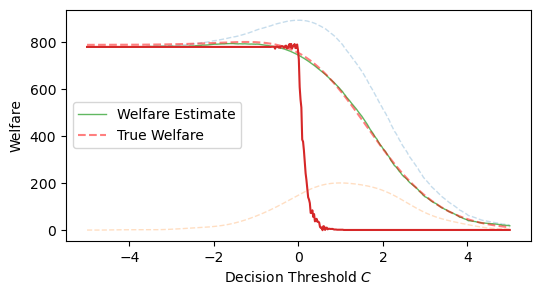

In [15]:
np.random.seed(19)
true_effects = estimates
n = len(true_effects)

## mispecify the distribution
dof = 1000
Xs = estimates + ((dof - 2)/dof)*np.random.standard_t(dof, size = n)*sigmas 

## misspecify the variance
sigmas *= 1 + np.random.normal(0.0, 0.02)
ts = Xs/sigmas

_ = methods.heteroskedastic_normal_welfare_estimator(Xs, sigmas, true_effects=true_effects)


cb_welfare = methods.coupled_bootstrap(Xs, sigmas, eps = 0.01)
grid = np.linspace(-5, 5, len(cb_welfare))
plt.plot(grid, cb_welfare)